# 0. Setup

## 0.1. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pandas as pd
import tensorflow as tf
import numpy as np
import uncertainty_libr as unc
import matplotlib.pyplot as plt
from scipy.special import erfinv
from math import sqrt, erf, pi

from sklearn import preprocessing
from math import pi
from sklearn import metrics as me
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold


In [3]:
print(tf.__version__)

2.3.0


## 0.2. Data processing

In [4]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
dataset = pd.DataFrame(boston_dataset.data,columns=boston_dataset.feature_names)
dataset['MEDV']=boston_dataset.target

In [5]:
dataset

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [6]:
dataset.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
dataset.fillna(0)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [8]:
from sklearn.model_selection import train_test_split
train_dataset,test_dataset = train_test_split(dataset,test_size=0.2,random_state=42)

In [9]:
label_column = 'MEDV'
input_column = train_dataset.columns.drop(['MEDV'])

In [10]:
x_train = train_dataset[input_column].astype(np.float32)
y_train = train_dataset[label_column].astype(np.float32)

x_test = test_dataset[input_column].astype(np.float32)
y_test = test_dataset[label_column].astype(np.float32)

## 0.4 Certainty Losses

In [87]:
def ECE_normal_loss(y_actual,y_pred):
    return unc.tf_ECE(y_actual[:,0],y_pred[:,0],y_pred[:,1],'normal',RMSE_mult=1,CE_mult=1,mpiw_mult=0.1)

def ECE_log_normal_loss(y_actual,y_pred):
    return unc.tf_ECE(y_actual[:,0],y_pred[:,0],y_pred[:,1],'log_normal',RMSE_mult=1,CE_mult=1,mpiw_mult=0.125)

def ECE_logistic_loss(y_actual,y_pred):
    return unc.tf_ECE(y_actual[:,0],y_pred[:,0],y_pred[:,1],'logistic',RMSE_mult=1,CE_mult=1,mpiw_mult=0.15)

def ECE_shifted_rayleigh_loss(y_actual,y_pred):
    return unc.tf_ECE(y_actual[:,0],y_pred[:,0],y_pred[:,1],'shifted_rayleigh',RMSE_mult=1,CE_mult=1,mpiw_mult=0.55)

def ECE_loss_normal_distr(y_actual,y_pred):
    return unc.tf_ECE_normal(y_actual[:,0],y_pred[:,0],y_pred[:,1])

def ECE_loss_shifted_log_normal_distr(y_actual,y_pred):
    return unc.tf_shifted_log_normal(y_actual[:,0],y_pred[:,0],y_pred[:,1],y_pred[:,2])

def QD_loss(y_actual,y_pred):
    return unc.tf_qd(y_actual[:,0],y_pred[:,0],y_pred[:,1],lambda_=0.4)

# 1. Neural Network

## 1.1. Preprocessing Setup

In [37]:
from sklearn.feature_selection import SelectKBest, f_regression

In [38]:
LEARNING_RATE = 0.005
DECAY = 0.98
N_EPOCHS = 400
TOLERANCE = 0.005
early_stopping = False
BATCH_SIZE = 128

In [39]:
scale = True
if scale:
    x_scaler = preprocessing.MinMaxScaler((0, 1))
    y_scaler = preprocessing.MinMaxScaler((0, 1))

    processed_x_train = x_scaler.fit_transform(x_train)
    processed_y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    processed_x_test = x_scaler.transform(x_test)
    processed_y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

else:
    processed_x_train = x_train.values
    processed_y_train = y_train.values.reshape(-1, 1)

    processed_x_test = x_test.values
    processed_y_test = y_test.values.reshape(-1,1)

In [40]:
inp_dim = processed_x_test.shape[1]

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        processed_x_train,
        processed_y_train
    )
).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        processed_x_test,    
        processed_y_test
    )
).batch(BATCH_SIZE)

In [69]:
def loss(model, x, y,distr):
    #return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, model(x))))
    
    #return ECE_shifted_rayleigh_loss(y,model(x))
    #return ECE_loss_normal_distr(y,model(x))
    if distr=="shifted_rayleigh":
        return ECE_shifted_rayleigh_loss(y,model(x))
    elif distr=="logistic":
        return ECE_logistic_loss(y,model(x))
    else:
        return ECE_normal_loss(y,model(x))
    
    #return ECE_log_normal_loss(y,model(x))

    #return ECE_loss_shifted_log_normal_distr(y,model(x))
    
    #return QD_loss(y,model(x))

def grad(model, inputs, targets,distr):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets,distr)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [43]:
def ECE_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(13, activation='relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation='relu'),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation='linear',bias_initializer=tf.keras.initializers.Constant(value=[1.0,0.0])) 
    ])

    #model.compile(loss=ECE_loss_normal,
    #            optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## 1.3. NN Training

In [44]:
processed_x_train, processed_x_recal, processed_y_train, y_recal = train_test_split(processed_x_train,processed_y_train, test_size=0.2, random_state=42)

In [88]:
Runs = 1
Ensembles = 5
alpha=0.1

n_std_devs = sqrt(2.0)*erfinv(1-alpha)

RMSE_t = []
MAE_t = []
ME_t =[]
R2_t =[]
pinaw_t = []
pinaw_p_t = []
picp_t = []
adce_t = []
dce_t = []

eval_p = 0.95

distr = 'normal'

import tqdm
import datetime
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE,beta_1=DECAY)

start_time = datetime.datetime.now()

for i in range(Runs):
    y_pred_all = []
    y_pred_iso = []
    
    for j in range(Ensembles):
        print("Starting run "+str(i+1)+" of "+str(Runs)+" -- with ensemble "+str(j+1)+" of "+str(Ensembles))

        real_model=ECE_model()

        # Keep results for plotting
        real_train_loss_results = []
        real_test_loss_results = []

        for epoch in range(N_EPOCHS):
            epoch_train_loss_avg = tf.keras.metrics.Mean()
            epoch_test_loss_avg = tf.keras.metrics.Mean()
            # Training loop - using batches of 32    
            
            
            #train_sort = processed_x_train[:,epoch%processed_x_train.shape[1]].argsort()
            #x_t = processed_x_train[train_sort]
            #y_t = processed_y_train[train_sort]
            
            for x,y in train_dataset:#for i in range(len(x_t)%BATCH_SIZE):#,ascii=True,desc='Training epoch '+str(epoch)):
                # Optimize the model
                #x = x_t[i*30:(i+1)*30]
                #y = y_t[i*30:(i+1)*30]
                
                loss_value, grads = grad(real_model, x, y,distr)
                optimizer.apply_gradients(zip(grads, real_model.trainable_variables))
                # Track progress
                epoch_train_loss_avg(loss_value)  # Add current batch loss
                # End epoch

            for x,y in test_dataset:
                # Optimize the model
                loss_value = loss(real_model, x, y,distr)
                # Track progress
                epoch_test_loss_avg(loss_value)  # Add current batch loss
                # End epoch

            real_train_loss_results.append(epoch_train_loss_avg.result())
            real_test_loss_results.append(epoch_test_loss_avg.result())

            if epoch > 0:
                if early_stopping and (real_test_loss_results[epoch] - min_real_test_loss_results > TOLERANCE * min_real_test_loss_results):
                    print(f'Early stopping at epoch {epoch} using tolerance {TOLERANCE}.')
                    print("Epoch {:03d}: Train Loss: {:.3f}".format(epoch, epoch_train_loss_avg.result()))
                    print("Epoch {:03d}: Test Loss: {:.3f}".format(epoch, epoch_test_loss_avg.result()))
                    break
                else:
                    min_real_test_loss_results = tf.minimum(min_real_test_loss_results, epoch_test_loss_avg.result())
            else:
                min_real_test_loss_results = epoch_test_loss_avg.result()

            if epoch % 100 == 0:
                print("Epoch {:03d}: Train Loss: {:.3f}".format(epoch, epoch_train_loss_avg.result()))
                print("Epoch {:03d}: Test Loss: {:.3f}".format(epoch, epoch_test_loss_avg.result()))

        print("\n")
        pred_arr = processed_x_test
        test_arr = processed_y_test
        out=real_model.predict(pred_arr)

        out_iso = real_model.predict(processed_x_recal)
        
        y_pred_all.append(out)
        y_pred_iso.append(out_iso)
        
        print("PICP: "+str(unc.PICP(out[:,0],out[:,1],test_arr[:,0])))
        print("NMIPW: "+str(unc.tf_PINAW_one_dim(test_arr[:,0],out[:,1],out[:,0]).numpy()))
        res,values,ece,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_arr,out[:,0],out[:,1],distr)
        print("ACE: "+str(ece.numpy()))
        print("\n")

    y_pred_all = tf.convert_to_tensor(y_pred_all,dtype=np.float32)

    upper = tf.reduce_mean(y_pred_all[:,:,0],axis=0)+n_std_devs*tf.math.reduce_std(y_pred_all[:,:,0],axis=0)/tf.math.sqrt(float(y_pred_all.shape[0]))
    lower = tf.reduce_mean(y_pred_all[:,:,1],axis=0)-n_std_devs*tf.math.reduce_std(y_pred_all[:,:,1],axis=0)/tf.math.sqrt(float(y_pred_all.shape[0]))

    up_temp = tf.math.maximum(upper,lower)
    lower = tf.math.minimum(upper,lower)
    upper=up_temp
    
    #pinaw = unc.tf_PINAW_one_dim(test_arr[:,0],upper,lower).numpy()
    sigm = unc.tf_calculate_sigma(upper,lower,distr)
    Y_pred,diff=unc.tf_calculate_mean(upper,lower,sigm,distr)
    res,values,adce,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_arr,upper,lower,distr)
    dce = 2*np.mean(res-values)
    
    if distr =="logistic":
        p_low = (1-eval_p)/2
        p_up = (1+eval_p)/2
        upper_p=Y_pred+sigm*np.log(p_up/(1-p_up))
        lower_p=Y_pred+sigm*np.log(p_low/(1-p_low))
        
    elif distr =="shifted_rayleigh":
        p_low = (1-eval_p)/2
        p_up = (1+eval_p)/2
        upper_p=Y_pred-sigm+sqrt(-2*np.log(1-p_up))*sigm
        lower_p=Y_pred-sigm+sqrt(-2*np.log(1-p_low))*sigm
        
    elif distr =="normal":
        upper_p=Y_pred+sigm*sqrt(2)*erfinv(eval_p)
        lower_p=Y_pred-sigm*sqrt(2)*erfinv(eval_p)
        
    #hard_picp = unc.PICP(upper,lower,test_arr[:,0])
    hard_picp = unc.PICP(upper_p,lower_p,test_arr[:,0])
    pinaw = unc.tf_PINAW_one_dim(test_arr[:,0],upper_p,lower_p).numpy()
    
    idx_above_evalp = np.where(res.numpy()>=eval_p)[0]
    if len(idx_above_evalp)>0:
        pinaw_p = pinaw_plot[idx_above_evalp[0]].numpy()
    else:
        pinaw_p = np.nan
    
    R2_total,RMSE_total,MAE_total,ME_total = unc.scores_calc_print(y_scaler.inverse_transform(Y_pred.numpy().reshape(-1,1)),y_scaler.inverse_transform(test_arr),False)


    RMSE_t = np.append(RMSE_t,RMSE_total)
    MAE_t = np.append(MAE_t,MAE_total)
    ME_t =np.append(ME_t,ME_total)
    R2_t =np.append(R2_t,R2_total)
    pinaw_t = np.append(pinaw_t,pinaw)
    pinaw_p_t = np.append(pinaw_p_t,pinaw_p)
    picp_t = np.append(picp_t,hard_picp)
    adce_t = np.append(adce_t,adce)
    dce_t = np.append(dce_t,dce)
    
end_time = datetime.datetime.now()
total_time = end_time - start_time

print('seconds taken:', round(total_time.total_seconds(),1),'\nstart_time:', start_time.strftime('%H:%M:%S'),'end_time:', end_time.strftime('%H:%M:%S'))

Starting run 1 of 1 -- with ensemble 1 of 5
Epoch 000: Train Loss: 0.422
Epoch 000: Test Loss: 0.284
Epoch 100: Train Loss: 0.083
Epoch 100: Test Loss: 0.107
Epoch 200: Train Loss: 0.061
Epoch 200: Test Loss: 0.098
Epoch 300: Train Loss: 0.055
Epoch 300: Test Loss: 0.110


PICP: 0.6372549019607843
NMIPW: 0.11100165
ACE: 0.32735246


Starting run 1 of 1 -- with ensemble 2 of 5
Epoch 000: Train Loss: 0.320
Epoch 000: Test Loss: 0.267
Epoch 100: Train Loss: 0.073
Epoch 100: Test Loss: 0.097
Epoch 200: Train Loss: 0.062
Epoch 200: Test Loss: 0.096
Epoch 300: Train Loss: 0.055
Epoch 300: Test Loss: 0.096


PICP: 0.7058823529411765
NMIPW: 0.113132924
ACE: 0.1812591


Starting run 1 of 1 -- with ensemble 3 of 5
Epoch 000: Train Loss: 0.385
Epoch 000: Test Loss: 0.271
Epoch 100: Train Loss: 0.075
Epoch 100: Test Loss: 0.096
Epoch 200: Train Loss: 0.065
Epoch 200: Test Loss: 0.098
Epoch 300: Train Loss: 0.062
Epoch 300: Test Loss: 0.098


PICP: 0.7843137254901961
NMIPW: 0.13126822
ACE: 0.136728

In [531]:
#Voert een log-transform uit op de input data X
#transformer = FunctionTransformer(np.log1p) 
#X_log_transformed = transformer.transform(X)
#pca = PCA(n_components=10)
#X_pca = pca.fit_transform(X_log_transformed)
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, 
#                                                    test_size=0.33, random_state=42)
#m = model(hyperparameters)
#m.fit(X_train)

#Tune de hyperparameters
#print(performance_metric(m.predict(X_train),y_train))

## 1.4. NN Evaluation

In [89]:
print(10*"-"+"RESULTS of "+str(Runs)+" runs"+10*"-")
print(f"RMSE: {np.mean(RMSE_t):.3f} +/- ({np.std(RMSE_t)/np.sqrt(Runs):.3f})")
print(f"MAE: {np.mean(MAE_t):.3f} +/- ({np.std(MAE_t)/np.sqrt(Runs):.3f})")
print(f"ME: {np.mean(ME_t):.3f} +/- ({np.std(ME_t)/np.sqrt(Runs):.3f})")
print(f"R2: {np.mean(R2_t):.3f} +/- ({np.std(R2_t)/np.sqrt(Runs):.3f})")
print(f"NMPIW: {np.mean(pinaw_t):.3f} +/- ({np.std(pinaw_t)/np.sqrt(Runs):.3f})")
print(f"NMPIW_p: {np.mean(pinaw_p_t):.3f} +/- ({np.std(pinaw_p_t)/np.sqrt(Runs):.3f})")
print(f"PICP: {np.mean(picp_t):.3f} +/- ({np.std(picp_t)/np.sqrt(Runs):.3f})")
print(f"ADCE: {np.mean(adce_t):.3f} +/- ({np.std(adce_t)/np.sqrt(Runs):.3f})")
print(f"DCE: {np.mean(dce_t):.3f} +/- ({np.std(dce_t)/np.sqrt(Runs):.3f})")


----------RESULTS of 1 runs----------
RMSE: 2.884 +/- (0.000)
MAE: 1.928 +/- (0.000)
ME: -0.241 +/- (0.000)
R2: 0.873 +/- (0.000)
NMPIW: 0.202 +/- (0.000)
NMPIW_p: 0.215 +/- (0.000)
PICP: 0.941 +/- (0.000)
ADCE: 0.044 +/- (0.000)
DCE: 0.036 +/- (0.000)


In [90]:
res,values,adce,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_arr,upper,lower,distr)

In [56]:
test_sort = test_arr[:,0][test_arr[:,0].argsort()]
upper_sort = upper.numpy()[test_arr[:,0].argsort()]
lower_sort = lower.numpy()[test_arr[:,0].argsort()]

In [57]:
"""max_range = 3
for i in range(max_range):
    ix1 = i*int(100/max_range)
    ix2 = (i+1)*int(100/max_range)
    res,values,adce,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_sort[ix1:ix2],upper_sort[ix1:ix2],lower_sort[ix1:ix2],distr,max_points=1000.0)
    #print(adce)"""

'max_range = 3\nfor i in range(max_range):\n    ix1 = i*int(100/max_range)\n    ix2 = (i+1)*int(100/max_range)\n    res,values,adce,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_sort[ix1:ix2],upper_sort[ix1:ix2],lower_sort[ix1:ix2],distr,max_points=1000.0)\n    #print(adce)'

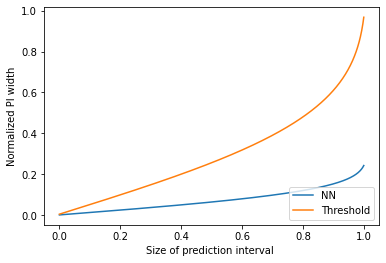

In [58]:
plt.figure(figsize=(6,4))
ax = plt.gca()

#diff = np.sum(np.abs(np.subtract(values,res)))
#print("NN CE: "+str(ce))
plt.plot(np.arange(0,1.0,1.0/len(values)),pinaw_plot,label='NN')
plt.plot(np.arange(0,1.0,1.0/len(values)),widths,label='Threshold')
#plt.xticks(np.arange(0, 1.1, 0.1),np.round(values[0::100],2))#, np.round(values[0::10],2))
#plt.locator_params(axis='x', nbins=len(values)/10)
plt.xlabel('Size of prediction interval ')
plt.ylabel('Normalized PI width')
    
plt.legend(loc='lower right')
plt.show() 

In [74]:
#res_gaussian = res
#res_QD = res
#res_badly_optimized = res

--
NN ACE: 0.04457829147577286


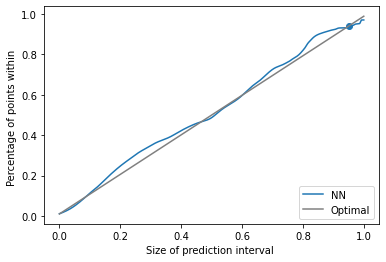

In [91]:
plt.figure(figsize=(6,4))
ax = plt.gca()
print("--")

diff = 2*np.mean(np.abs(np.subtract(values[10:],res[10:])))
print("NN ACE: "+str(diff))
#print("NN CE: "+str(ce))
plt.plot(np.arange(0,1.0,1.0/len(values)),res,label='NN')
plt.plot(np.arange(0,1.0,1.0/len(values)),values,label='Optimal',color='gray')
#plt.scatter(0.9,np.mean(picp_t),marker="x",color='red',s=100)
#plt.xticks(np.arange(0, 1.1, 0.1),np.round(values[0::100],2))#, np.round(values[0::10],2))
#plt.locator_params(axis='x', nbins=len(values)/10)
plt.xlabel('Size of prediction interval ')
plt.scatter(0.95,0.941)
plt.ylabel('Percentage of points within ')
    
plt.legend(loc='lower right')
plt.show() 

--


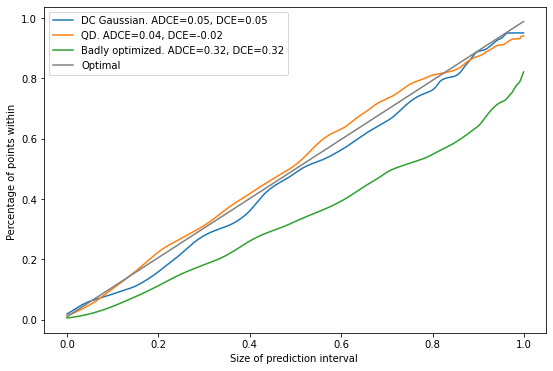

In [86]:
plt.figure(figsize=(9,6))
ax = plt.gca()
print("--")

diff_gaussian = 2*np.mean(np.abs(np.subtract(values[10:],res_gaussian[10:])))
diff_qd = 2*np.mean(np.abs(np.subtract(values[10:],res_QD[10:])))
diff_bad = 2*np.mean(np.abs(np.subtract(values[10:],res_badly_optimized[10:])))
dce_gaussian = 2*np.mean((np.subtract(values[10:],res_gaussian[10:])))
dce_qd = 2*np.mean((np.subtract(values[10:],res_QD[10:])))
dce_bad = 2*np.mean((np.subtract(values[10:],res_badly_optimized[10:])))
#print("NN CE: "+str(ce))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gaussian,label='DC Gaussian. ADCE='+str(np.round(diff_gaussian,2))+', DCE='+str(np.round(dce_gaussian,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_QD,label='QD. ADCE='+str(np.round(diff_qd,2))+', DCE='+str(np.round(dce_qd,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_badly_optimized,label='Badly optimized. ADCE='+str(np.round(diff_bad,2))+', DCE='+str(np.round(dce_bad,2)))
plt.plot(np.arange(0,1.0,1.0/len(values)),values,label='Optimal',color='gray')
#plt.scatter(0.9,np.mean(picp_t),marker="x",color='red',s=100)
#plt.xticks(np.arange(0, 1.1, 0.1),np.round(values[0::100],2))#, np.round(values[0::10],2))
#plt.locator_params(axis='x', nbins=len(values)/10)
plt.xlabel('Size of prediction interval ')
#plt.scatter(0.95,0.941)
plt.ylabel('Percentage of points within ')
    
plt.legend(loc='upper left')
plt.show() 

In [435]:
pinaw_plot[np.where(res.numpy()>=0.95)[0][0]].numpy()

0.22897288

In [280]:
upper_95 = Y_pred+1.96*sigm
lower_95 = Y_pred-1.96*sigm

In [46]:
unc.scores_calc_print(y_scaler.inverse_transform(Y_pred.numpy().reshape(-1,1)),y_scaler.inverse_transform(test_arr),True)
print("PINAW: "+str(pinaw))

RMSE of total: 3.1203525317149947
MAE of total: 2.0644245
MdAE of total: 1.6521931
R² of total: 0.8530212402456764
ME of total: [-0.2925414]
Std of results: 3.1066089384366538


PINAW: 0.17051597


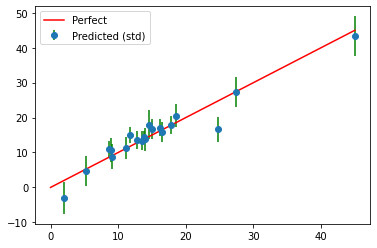

In [47]:
start = 0
end = 20
plt.errorbar(processed_y_test[start:end]/y_scaler.scale_,Y_pred[start:end]/y_scaler.scale_,yerr=np.array([Y_pred-lower,upper-Y_pred])[:,start:end]/y_scaler.scale_, fmt='o',ecolor='green',label='Predicted (std)')
plt.plot(np.arange(0,50,5),np.arange(0,50,5),color='red',label='Perfect')
plt.legend()

In [48]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression()
y_pred_iso = tf.convert_to_tensor(y_pred_iso,dtype=np.float32)
upper_iso = tf.reduce_mean(y_pred_iso[:,:,0],axis=0)+n_std_devs*tf.math.reduce_std(y_pred_iso[:,:,0],axis=0)/tf.math.sqrt(float(y_pred_iso.shape[0]))
lower_iso = tf.reduce_mean(y_pred_iso[:,:,1],axis=0)-n_std_devs*tf.math.reduce_std(y_pred_iso[:,:,1],axis=0)/tf.math.sqrt(float(y_pred_iso.shape[0]))

res_recal,values_recal,adce_recal,pinaw_plot,dce_width,widths = unc.tf_ce_plot(y_recal,upper_iso,lower_iso,distr)


In [166]:
iso_reg.fit(res_recal,values_recal)
#res = iso_reg.predict(res_recal)

IsotonicRegression()

In [167]:
res,values,adce,pinaw_plot,dce_width,widths=unc.tf_ce_plot(test_arr,upper,lower,distr)
res = iso_reg.predict(res)

In [266]:
print(f'number of parameters in the model {real_model.count_params()}')

number of parameters in the model 984
